<a href="https://colab.research.google.com/github/stchang-idm/nutrition_tb_workshop/blob/main/sample_size_calculations_bmi_effects_2025_01_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sample Size Calculation for Trials Comparing Control, RATIONS, and Micro-Alone

## Introduction

In this analysis, we aim to determine the required sample sizes for **cluster-randomized** or **household-randomized** trials comparing nutritional interventions to reduce tuberculosis (TB) incidence among household contacts of TB patients. We consider different scenarios:

- **Scenario 1 (Cluster-Level Randomization)**: Randomization at the tuberculosis-unit (TU) level.
- **Scenario 2 (Household-Level Randomization)**: Randomization at the household level.
- **Scenario 2B (Household-Level + Low-BMI Sensitivity)**: A variation of Scenario 2 incorporating different BMI subgroups with different baseline incidences and different efficacies.
- **Scenario 3 (Using RATIONS Data-Informed ICC Values)**: Substituting the ICC values observed in the RATIONS trial.

We compare **Control** to two interventions:

1. **RATIONS**: A nutritional intervention providing macronutrients + RDA levels of micronutrients.
2. **Micro-Alone**: A micronutrient-only intervention providing additional B vitamins + RDA levels for other micronutrients.

> **Note**: We do not require Micro-Alone to demonstrate superiority over RATIONS. Instead, each arm is tested against **Control** to assess whether it can reduce TB incidence. We also favor the simpler 2- and 3-arm designs rather than 2 x 2 factorial (micro x macro) designs due to statistical considerations discussed elsewhere.

---
## Basic Algorithm

Below is our approach for calculating sample sizes applied over each scenario (cluster-level, household-level, or updated ICC values):

1. **Adjust Significance Level** (if multiple comparisons): Optionally use the Bonferroni correction (or another method) to adjust \($\alpha$) if multiple arms are tested simultaneously.

2. **Calculate Z-Scores**: Determine the critical values for \($\alpha$) (two-sided) and power \(1 - $\beta$).

     $$ Z_{\alpha} = Z_{1 - \alpha/2} $$
     $$ Z_{\beta} = Z_{1 - \beta} $$

3. **Define Incidence Rates**:

    - Incidence in RATIONS group: $$ p_1 = p_{\text{control}} (1 - \text{eff}_{\text{RATIONS}}) $$
    - Incidence in Micro-Alone group: $$ p_2 = p_{\text{control}} (1 - \text{eff}_{\text{Micro-Alone}}) $$

4. **Calculate Effect Size**:
    $$ \delta = p_1 - p_2 $$

5. **Compute Sample Size Without Clustering**:
    $$ n = \frac{(Z_{\alpha} + Z_{\beta})^2 [p_1(1 - p_1) + p_2(1 - p_2)]}{\delta^2} $$

6. **Adjust for Clustering**:

    - For cluster-level randomization: $$ \text{DE} = 1 + (n_e - 1) r + n_e (n_s - 1) \rho $$
    - For household-level randomization: $$ \text{DE} = 1 + (n_e - 1) r $$

   Then \(n_{\text{adjusted}} = n \times \text{DE}.\)

7. **Determine Total Sample Size**:

   - For cluster-level randomization:
     - Total individuals per cluster (TU):
       $$
       m = n_e \times n_s
       $$
     - Number of clusters per group:
       $$
       K = \frac{n_{\text{adjusted}}}{m}
       $$
   - For household-level randomization:
     - Number of households per group:
       $$
       K = \frac{n_{\text{adjusted}}}{n_e}
       $$
       
8. **Generate 2D Heatmaps** for parameter sweeps (baseline incidence, efficacy, or other factors).

---

## Import Libraries

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
from matplotlib.patches import Rectangle
%matplotlib inline

## Parameters and Setup


In [30]:
# Significance & Power
alpha = 0.05  # single comparison alpha
Z_alpha = stats.norm.ppf(1 - alpha / 2)
power = 0.80
Z_beta = stats.norm.ppf(power)

# Range of baseline incidence rates (3% to 7% in 0.5 increments)
baseline_incidence_percent = np.arange(3, 7.5, 0.5)
baseline_incidences = baseline_incidence_percent / 100.0

# Efficacies
efficacy_rations = 0.48  # RATIONS
micro_alone_efficacies = [0.25, 0.30, 0.35, 0.40, 0.45, 0.48, 0.60]  # Micro-Alone
print("Efficacy of RATIONS = 48%. Micro-Alone efficacies range 25% to 60%.")

Efficacy of RATIONS = 48%. Micro-Alone efficacies range 25% to 60%.


# Scenario 1: Cluster-Level Randomization

In [31]:
# Cluster-level parameters
ne = 5   # individuals per household
ns = 100 # households per TU
r = 0.2  # ICC within households
rho = 0.01  # ICC between households in a TU

DE_cluster = 1 + (ne - 1)*r + ne*(ns - 1)*rho
print(f"Scenario 1: Cluster-Level Randomization. DE = {DE_cluster:.2f}")

def cluster_size_calc(p_control, eff, Z_alpha, Z_beta, DE, ne, ns):
    p1 = p_control  # Control
    p2 = p_control * (1 - eff)
    delta = p1 - p2
    if abs(delta) < 1e-12:
        delta = 1e-12

    numerator = (Z_alpha + Z_beta)**2 * (p1*(1-p1) + p2*(1-p2))
    denominator = delta**2
    n_per_group = numerator / denominator
    n_per_group_adj = n_per_group * DE

    m = ne * ns
    K = n_per_group_adj / m
    K_per_group = math.ceil(K)
    total_clusters = K_per_group * 2
    total_individuals = total_clusters * m
    return total_individuals

Scenario 1: Cluster-Level Randomization. DE = 6.75


In [32]:
# Control vs. RATIONS, 48%
scenario1_rations_sizes = np.zeros(len(baseline_incidences))
for j, p_control in enumerate(baseline_incidences):
    scenario1_rations_sizes[j] = cluster_size_calc(
        p_control=p_control,
        eff=efficacy_rations,
        Z_alpha=Z_alpha,
        Z_beta=Z_beta,
        DE=DE_cluster,
        ne=ne,
        ns=ns
    )

# Control vs. Micro-Alone
scenario1_micro_sizes = np.zeros((len(micro_alone_efficacies), len(baseline_incidences)))
for i, eff_micro in enumerate(micro_alone_efficacies):
    for j, p_control in enumerate(baseline_incidences):
        scenario1_micro_sizes[i, j] = cluster_size_calc(
            p_control=p_control,
            eff=eff_micro,
            Z_alpha=Z_alpha,
            Z_beta=Z_beta,
            DE=DE_cluster,
            ne=ne,
            ns=ns
        )

## Plots for Scenario 1 (Cluster-Level)


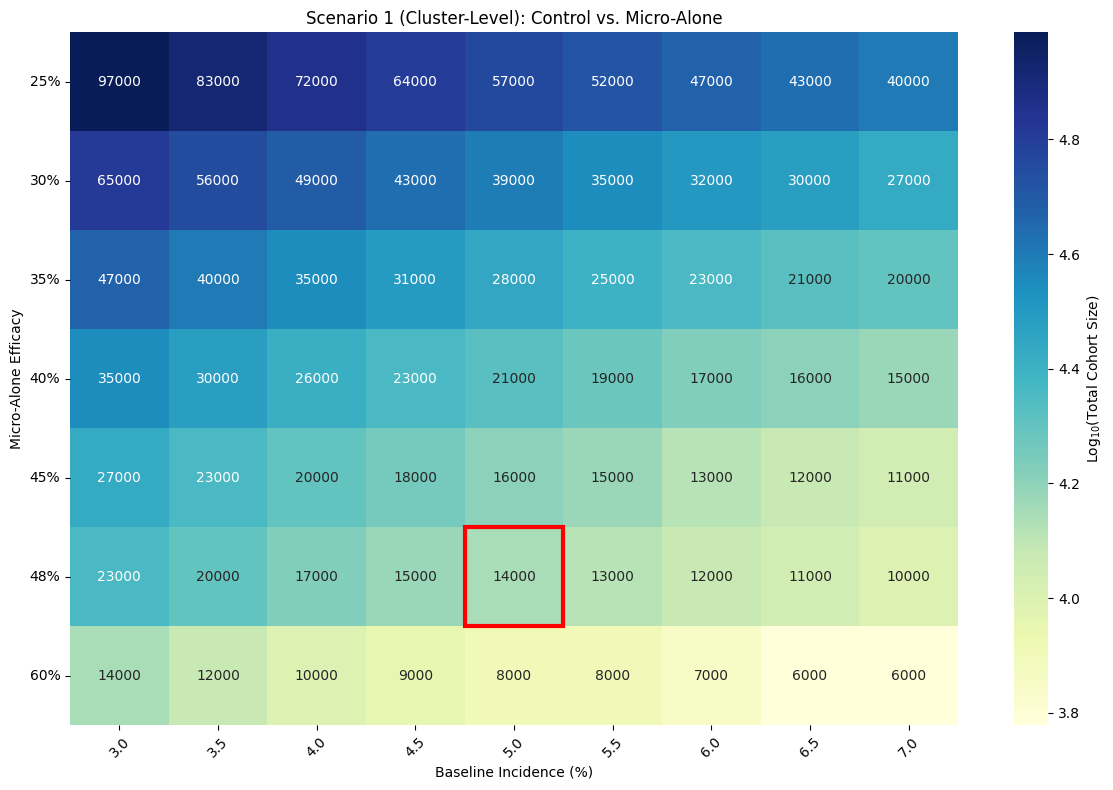

In [46]:
# Micro-Alone heatmap
log_micro1 = np.log10(scenario1_micro_sizes)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    log_micro1,
    annot=scenario1_micro_sizes.astype(int),
    fmt="",
    cmap='YlGnBu',
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"{int(100*e)}%" for e in micro_alone_efficacies],
    cbar_kws={'label': 'Log$_{10}$(Total Cohort Size)'}
)
plt.title("Scenario 1 (Cluster-Level): Control vs. Micro-Alone")
plt.xlabel("Baseline Incidence (%)")
plt.ylabel("Micro-Alone Efficacy")

# Find the coordinates of the reference cell
efficacy_index = micro_alone_efficacies.index(0.48)
incidence_index = list(baseline_incidence_percent).index(5.0)

# Add a red rectangle to highlight the reference cell
ax.add_patch(Rectangle((incidence_index, efficacy_index), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# # RATIONS line plot
# plt.figure(figsize=(8, 5))
# plt.plot(baseline_incidence_percent, scenario1_rations_sizes, marker='o', label="RATIONS (48%)")
# plt.title("Scenario 1 (Cluster-Level): Control vs. RATIONS")
# plt.xlabel("Baseline Incidence (%)")
# plt.ylabel("Total Cohort Size")
# plt.grid(True)
# plt.legend()
# plt.show()

# Scenario 2: Household-Level Randomization

Here, each household is randomized to one of the arms. The design effect:
\(
   \text{DE}_{\text{household}} = 1 + (n_e - 1) r.
\)


In [34]:
m_household = 5   # average individuals per household
r_household = 0.2 # ICC within a household
DE_household = 1 + (m_household - 1)*r_household
print(f"Scenario 2: Household-Level Randomization. DE = {DE_household:.2f}")

def household_size_calc(p_control, eff, Z_alpha, Z_beta, DE, n_e):
    p1 = p_control
    p2 = p_control * (1 - eff)
    delta = p1 - p2
    if abs(delta) < 1e-12:
        delta = 1e-12

    numerator = (Z_alpha + Z_beta)**2 * (p1*(1-p1) + p2*(1-p2))
    denominator = delta**2
    n_per_group = numerator / denominator
    n_per_group_adj = n_per_group * DE

    # number of households per group
    K = n_per_group_adj / n_e
    K_per_group = math.ceil(K)

    # total households (2 arms)
    total_households = K_per_group * 2
    total_individuals = total_households * n_e
    return total_individuals

Scenario 2: Household-Level Randomization. DE = 1.80


In [35]:
# Control vs. RATIONS
scenario2_rations_sizes = np.zeros(len(baseline_incidences))
for j, p_control in enumerate(baseline_incidences):
    scenario2_rations_sizes[j] = household_size_calc(
        p_control=p_control,
        eff=efficacy_rations,
        Z_alpha=Z_alpha,
        Z_beta=Z_beta,
        DE=DE_household,
        n_e=m_household
    )

# Control vs. Micro-Alone
scenario2_micro_sizes = np.zeros((len(micro_alone_efficacies), len(baseline_incidences)))
for i, eff_micro in enumerate(micro_alone_efficacies):
    for j, p_control in enumerate(baseline_incidences):
        scenario2_micro_sizes[i, j] = household_size_calc(
            p_control=p_control,
            eff=eff_micro,
            Z_alpha=Z_alpha,
            Z_beta=Z_beta,
            DE=DE_household,
            n_e=m_household
        )

## Plots for Scenario 2 (Household-Level)


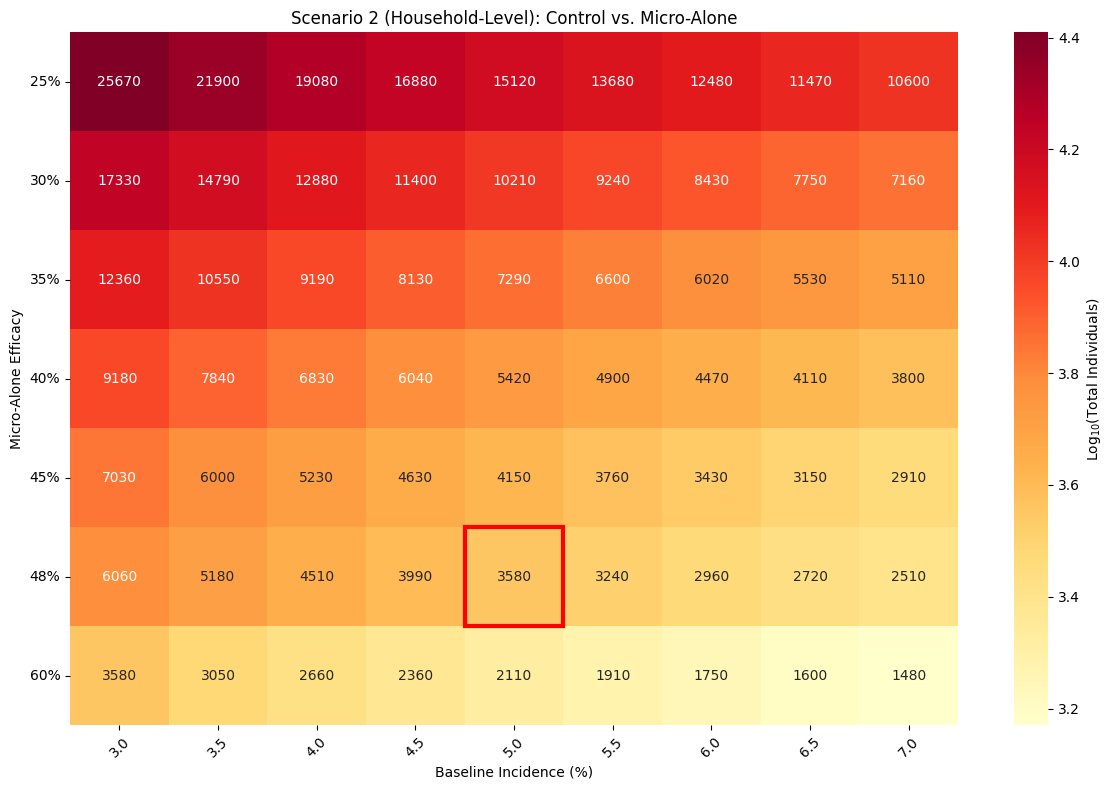

In [45]:
# Micro-Alone heatmap
log_micro2 = np.log10(scenario2_micro_sizes)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    log_micro2,
    annot=scenario2_micro_sizes.astype(int),
    fmt="",
    cmap='YlOrRd',
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"{int(100*e)}%" for e in micro_alone_efficacies],
    cbar_kws={'label': 'Log$_{10}$(Total Individuals)'}
)
plt.title("Scenario 2 (Household-Level): Control vs. Micro-Alone")
plt.xlabel("Baseline Incidence (%)")
plt.ylabel("Micro-Alone Efficacy")

# Find the coordinates of the reference cell
efficacy_index = micro_alone_efficacies.index(0.48)
incidence_index = list(baseline_incidence_percent).index(5.0)

# Add a red rectangle to highlight the reference cell
ax.add_patch(Rectangle((incidence_index, efficacy_index), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# # RATIONS line plot
# plt.figure(figsize=(8, 5))
# plt.plot(baseline_incidence_percent, scenario2_rations_sizes, marker='o', color='r', label="RATIONS (48%)")
# plt.title("Scenario 2 (Household-Level): Control vs. RATIONS")
# plt.xlabel("Baseline Incidence (%)")
# plt.ylabel("Total Individuals")
# plt.grid(True)
# plt.legend()
# plt.show()

# Scenario 2B: Additional Sensitivity for Low-BMI vs. Higher-BMI Individuals

In this variation of **household-level randomization**, we account for **two BMI subgroups**:
- **25%** of the population is **low BMI** (<18.5) with **2x** the baseline TB incidence compared to the average.
- **75%** is **higher BMI**, with a **0.67x** baseline incidence (so that 0.25 * 2 + 0.75 * 0.67 ≈ 1.0, maintaining the overall baseline incidence at $p_{control}$).

We also assume that the **efficacy** in low-BMI individuals may differ from the efficacy in higher-BMI individuals by a **relative factor** $R$. For example:
- $R = 0.5$: The intervention is 50% **worse** in low-BMI individuals.
- $R = 2.0$: The intervention is 100% **better** in low-BMI individuals.

If the baseline efficacy for higher-BMI is $\text{eff}_{base}$, then the efficacy for low-BMI is $\text{eff}_{low} = R \times \text{eff}_{base}$.

**Important**: We still assume an overall baseline incidence $p_{control}$, but we break it down as:
$$
p_{low, control} = 2 \times p_{control}
$$ $$
p_{high, control} = 0.67 \times p_{control}
$$
so that the weighted average is
$$
0.25 \times 2 + 0.75 \times 0.67 = 1.0 \times p_{control}.
$$


In [37]:
# We'll define:
#   - eff_base: the efficacy for the higher-BMI group
#   - ratio R in [0.5..2] => eff_low = R * eff_base
#   - Then we compute p2 as the weighted average of low-BMI + high-BMI incidence.
# We keep the design effect from Scenario 2: DE_household.

ratio_values = np.arange(0.5, 2.1, 0.25)  # for instance 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0

def household_size_calc_BMI(
    p_control, eff_base, ratio, # ratio is how many times better (or worse) in low-BMI
    Z_alpha, Z_beta, DE, n_e
):
    """
    Calculate total sample size for a 2-arm trial (Control vs. 'Intervention')
    under household-level randomization, with separate BMI subgroups.
    """
    # Control arm = p1 = p_control

    # Low-BMI: 25% of population has incidence 2 * p_control in Control
    # High-BMI: 75% with incidence 0.67 * p_control in Control

    # Efficacies:
    eff_low = eff_base * ratio

    # Incidence in low-BMI under intervention
    p_low_int = 2.0 * p_control * (1 - eff_low)
    # Incidence in high-BMI under intervention
    p_high_int = 0.67 * p_control * (1 - eff_base)

    # Weighted average incidence in the intervention arm
    p2 = 0.25 * p_low_int + 0.75 * p_high_int
    p1 = p_control  # overall average incidence in Control

    delta = p1 - p2
    if abs(delta) < 1e-12:
        delta = 1e-12

    # 2-proportions formula
    numerator = (Z_alpha + Z_beta)**2 * (p1*(1-p1) + p2*(1-p2))
    denominator = delta**2
    n_per_group = numerator / denominator

    # Adjust for household-level DE
    n_per_group_adj = n_per_group * DE

    # number of households per group
    K = n_per_group_adj / n_e
    K_per_group = math.ceil(K)
    total_households = K_per_group * 2

    total_individuals = total_households * n_e
    return total_individuals

# We'll pick an example 'base' efficacy for the higher-BMI group.
# For instance, let's assume eff_base is 0.48 (like RATIONS), or some other.
eff_base_2B = 0.48  # or we could do Micro-Alone

# We'll do a 2D sweep: ratio_values x baseline_incidences
scenario2B_sizes = np.zeros((len(ratio_values), len(baseline_incidences)))

for i, ratio in enumerate(ratio_values):
    for j, p_control in enumerate(baseline_incidences):
        scenario2B_sizes[i, j] = household_size_calc_BMI(
            p_control=p_control,
            eff_base=eff_base_2B,
            ratio=ratio,
            Z_alpha=Z_alpha,
            Z_beta=Z_beta,
            DE=DE_household,
            n_e=m_household
        )


### Plots for Scenario 2B

We'll create a heatmap with **BMI efficacy ratio** on one axis (0.5–2.0) and **baseline incidence** on the other. The displayed values are the total sample size required under household-level randomization.


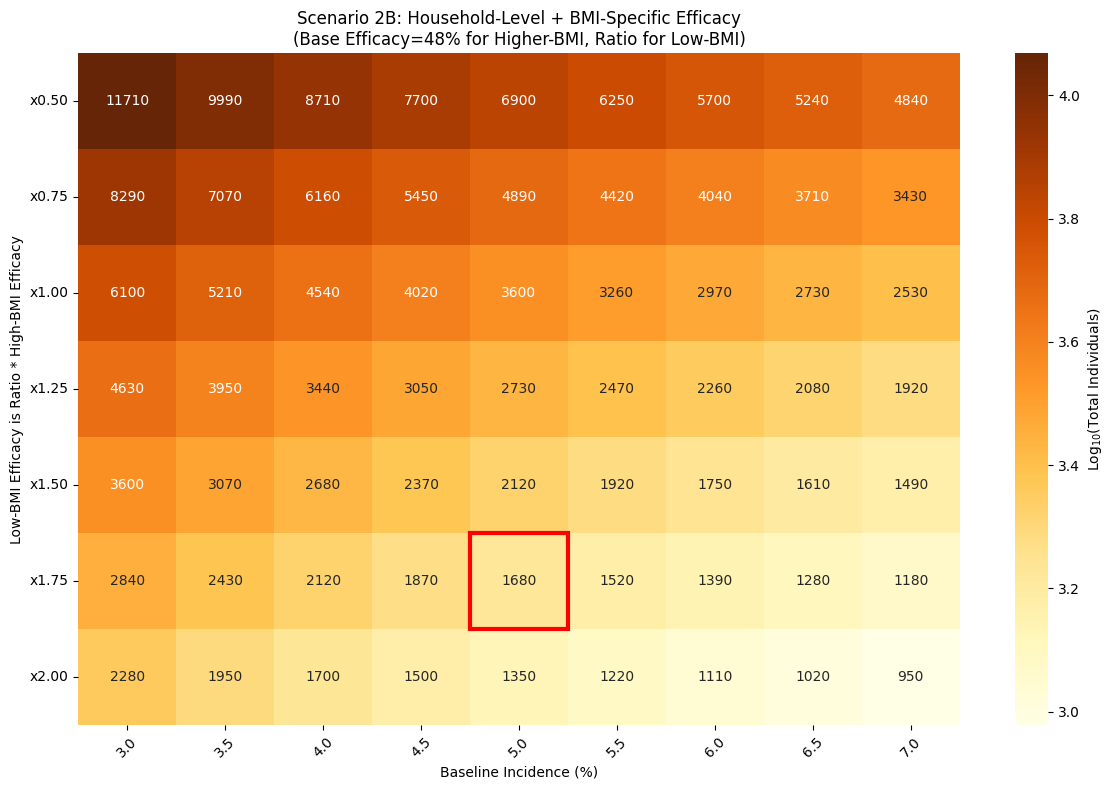

In [47]:
log_2B = np.log10(scenario2B_sizes)

plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    log_2B,
    annot=scenario2B_sizes.astype(int),
    fmt="",
    cmap='YlOrBr',
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"x{r:.2f}" for r in ratio_values],
    cbar_kws={'label': 'Log$_{10}$(Total Individuals)'}
)
plt.title("Scenario 2B: Household-Level + BMI-Specific Efficacy\n(Base Efficacy=48% for Higher-BMI, Ratio for Low-BMI)")
plt.xlabel("Baseline Incidence (%)")
plt.ylabel("Low-BMI Efficacy is Ratio * High-BMI Efficacy")

# Find the coordinates of the reference cell
efficacy_index = micro_alone_efficacies.index(0.48)
incidence_index = list(baseline_incidence_percent).index(5.0)

# Add a red rectangle to highlight the reference cell
ax.add_patch(Rectangle((incidence_index, efficacy_index), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Scenario 3: Using RATIONS Data-Informed ICC Values

In [39]:
ne_obs = 3.7
r_obs = 0.0036
ns_obs = 368
rho_obs = 0.0018

DE_cluster_obs = 1 + (ne_obs - 1)*r_obs + ne_obs*(ns_obs - 1)*rho_obs
DE_household_obs = 1 + (ne_obs - 1)*r_obs

print("Scenario 3: Observed RATIONS ICC values")
print(f"  DE_cluster_obs = {DE_cluster_obs:.3f}")
print(f"  DE_household_obs = {DE_household_obs:.3f}")

Scenario 3: Observed RATIONS ICC values
  DE_cluster_obs = 3.454
  DE_household_obs = 1.010


We'll reuse the existing functions but substitute the updated design effect and cluster sizes. Then we produce the same type of heatmaps/plots.


In [40]:
def cluster_size_calc_obs(p_control, eff, Z_alpha, Z_beta, DE, ne_obs, ns_obs):
    p1 = p_control
    p2 = p_control * (1 - eff)
    delta = p1 - p2
    if abs(delta) < 1e-12:
        delta = 1e-12

    numerator = (Z_alpha + Z_beta)**2 * (p1*(1-p1) + p2*(1-p2))
    denominator = delta**2
    n_per_group = numerator / denominator
    n_per_group_adj = n_per_group * DE

    m_obs = ne_obs * ns_obs
    K = n_per_group_adj / m_obs
    K_per_group = math.ceil(K)
    total_clusters = K_per_group * 2
    total_individuals = total_clusters * m_obs
    return total_individuals

def household_size_calc_obs(p_control, eff, Z_alpha, Z_beta, DE, ne_obs):
    p1 = p_control
    p2 = p_control * (1 - eff)
    delta = p1 - p2
    if abs(delta) < 1e-12:
        delta = 1e-12

    numerator = (Z_alpha + Z_beta)**2 * (p1*(1-p1) + p2*(1-p2))
    denominator = delta**2
    n_per_group = numerator / denominator
    n_per_group_adj = n_per_group * DE

    K = n_per_group_adj / ne_obs
    K_per_group = math.ceil(K)
    total_households = K_per_group * 2
    total_individuals = total_households * ne_obs
    return total_individuals

# For RATIONS vs. Control and Micro-Alone vs. Control
# 1) Cluster-level
scenario3_rations_cluster = np.zeros(len(baseline_incidences))
scenario3_micro_cluster = np.zeros((len(micro_alone_efficacies), len(baseline_incidences)))

for j, p_control in enumerate(baseline_incidences):
    scenario3_rations_cluster[j] = cluster_size_calc_obs(
        p_control, efficacy_rations, Z_alpha, Z_beta, DE_cluster_obs, ne_obs, ns_obs
    )

for i, eff_micro in enumerate(micro_alone_efficacies):
    for j, p_control in enumerate(baseline_incidences):
        scenario3_micro_cluster[i, j] = cluster_size_calc_obs(
            p_control, eff_micro, Z_alpha, Z_beta, DE_cluster_obs, ne_obs, ns_obs
        )

# 2) Household-level
scenario3_rations_house = np.zeros(len(baseline_incidences))
scenario3_micro_house = np.zeros((len(micro_alone_efficacies), len(baseline_incidences)))

for j, p_control in enumerate(baseline_incidences):
    scenario3_rations_house[j] = household_size_calc_obs(
        p_control, efficacy_rations, Z_alpha, Z_beta, DE_household_obs, ne_obs
    )

for i, eff_micro in enumerate(micro_alone_efficacies):
    for j, p_control in enumerate(baseline_incidences):
        scenario3_micro_house[i, j] = household_size_calc_obs(
            p_control, eff_micro, Z_alpha, Z_beta, DE_household_obs, ne_obs
        )

## Scenario 3 Plots


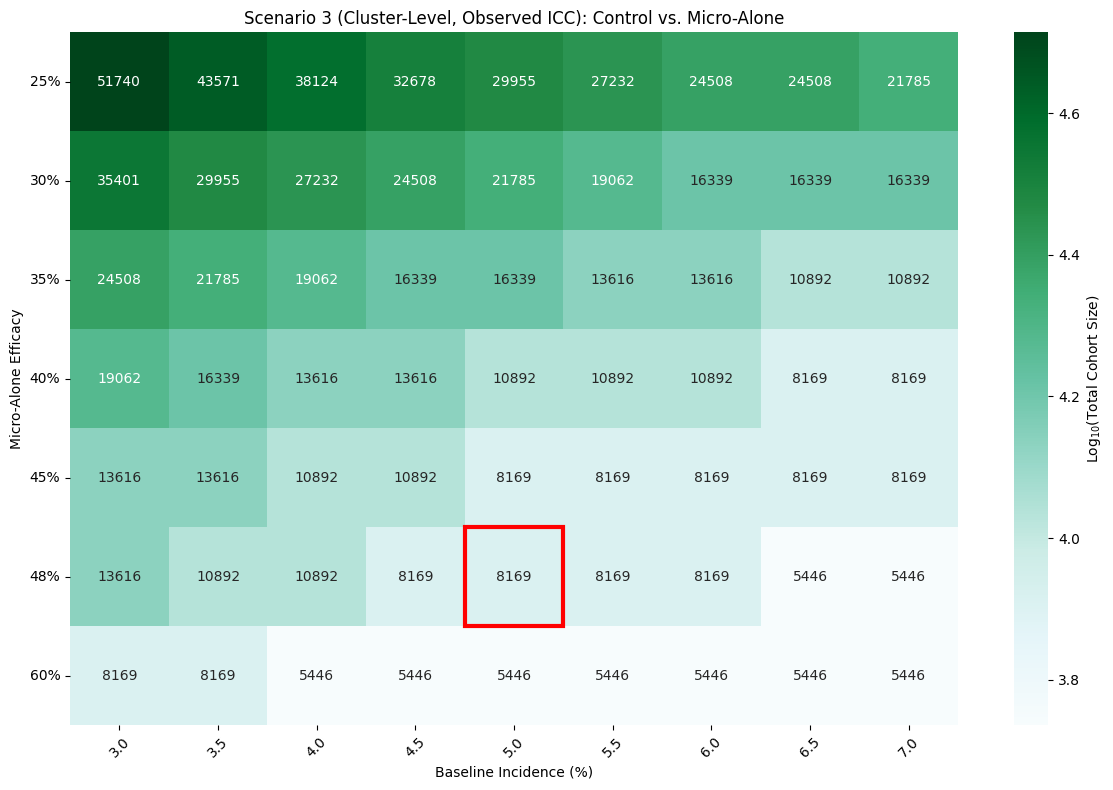

In [48]:
# Cluster-level, Micro-Alone heatmap
log_micro3_cluster = np.log10(scenario3_micro_cluster)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    log_micro3_cluster,
    annot=scenario3_micro_cluster.astype(int),
    fmt="",
    cmap='BuGn',
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"{int(100*e)}%" for e in micro_alone_efficacies],
    cbar_kws={'label': 'Log$_{10}$(Total Cohort Size)'}
)
plt.title("Scenario 3 (Cluster-Level, Observed ICC): Control vs. Micro-Alone")
plt.xlabel("Baseline Incidence (%)")
plt.ylabel("Micro-Alone Efficacy")

# Find the coordinates of the reference cell
efficacy_index = micro_alone_efficacies.index(0.48)
incidence_index = list(baseline_incidence_percent).index(5.0)

# Add a red rectangle to highlight the reference cell
ax.add_patch(Rectangle((incidence_index, efficacy_index), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# # Cluster-level, RATIONS line plot
# plt.figure(figsize=(8, 5))
# plt.plot(baseline_incidence_percent, scenario3_rations_cluster, marker='o', label="RATIONS (48%)")
# plt.title("Scenario 3 (Cluster-Level, Observed ICC): Control vs. RATIONS")
# plt.xlabel("Baseline Incidence (%)")
# plt.ylabel("Total Cohort Size")
# plt.grid(True)
# plt.legend()
# plt.show()

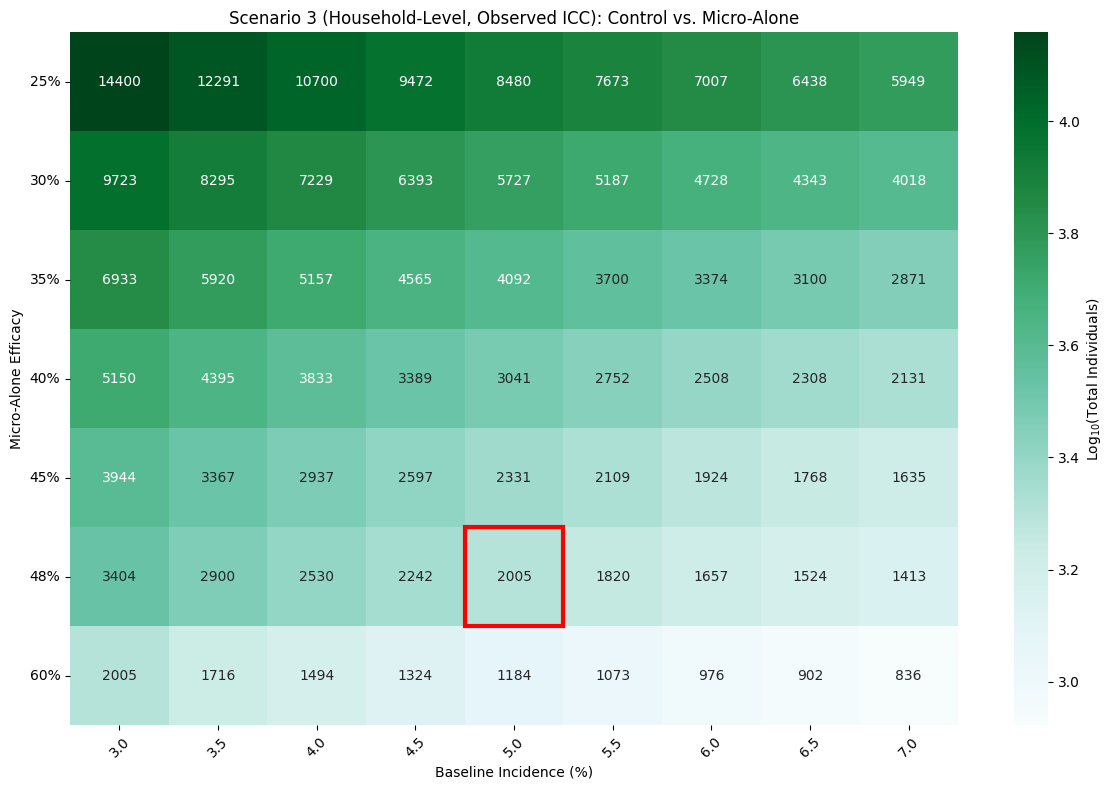

In [49]:
# Household-level, Micro-Alone heatmap
log_micro3_house = np.log10(scenario3_micro_house)
plt.figure(figsize=(12, 8))
ax = sns.heatmap(
    log_micro3_house,
    annot=scenario3_micro_house.astype(int),
    fmt="",
    cmap='BuGn',
    xticklabels=baseline_incidence_percent,
    yticklabels=[f"{int(100*e)}%" for e in micro_alone_efficacies],
    cbar_kws={'label': 'Log$_{10}$(Total Individuals)'}
)
plt.title("Scenario 3 (Household-Level, Observed ICC): Control vs. Micro-Alone")
plt.xlabel("Baseline Incidence (%)")
plt.ylabel("Micro-Alone Efficacy")

# Find the coordinates of the reference cell
efficacy_index = micro_alone_efficacies.index(0.48)
incidence_index = list(baseline_incidence_percent).index(5.0)

# Add a red rectangle to highlight the reference cell
ax.add_patch(Rectangle((incidence_index, efficacy_index), 1, 1, fill=False, edgecolor='red', lw=3))

plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# # Household-level, RATIONS line plot
# plt.figure(figsize=(8, 5))
# plt.plot(baseline_incidence_percent, scenario3_rations_house, marker='o', label="RATIONS (48%)")
# plt.title("Scenario 3 (Household-Level, Observed ICC): Control vs. RATIONS")
# plt.xlabel("Baseline Incidence (%)")
# plt.ylabel("Total Individuals")
# plt.grid(True)
# plt.legend()
# plt.show()

# Discussion & Interpretation

1. **Scenario 1 (Cluster-Level)**: We use a larger design effect from the original assumptions (ICC=0.2 within households, $(\rho=0.01)$ among households) -> potentially large sample sizes.
2. **Scenario 2 (Household-Level)**: A simpler design effect, ignoring TU-level clustering, typically yields smaller sample sizes.
3. **Scenario 2B (BMI-Specific Variation)**: If efficacy differs between low-BMI and higher-BMI individuals, the overall intervention incidence changes. Because 25% are low-BMI (2× risk) and 75% are higher-BMI (0.67× risk), the total effect depends on how efficacy scales in low-BMI vs. high-BMI. The heatmap shows how sample sizes can fluctuate if low-BMI efficacy is 50% worse (ratio=0.5) or 100% better (ratio=2.0) than the base efficacy.
4. **Scenario 3 (Observed ICCs)**: The RATIONS trial observed much smaller ICCs ($r=0.0036$, $\rho=0.0018$), dramatically reducing design effects and hence sample sizes.
5. **Multiple Comparisons**: If you formally test multiple arms (RATIONS, Micro-Alone) vs. Control in the same trial, consider a multiple-comparison correction (e.g., Bonferroni) if you want a strict family-wise $\alpha = 0.05\$.
6. **Sensitivity Analyses**: Variation in baseline incidence, ICC, and subgroup-specific efficacy are all crucial to realistically bounding sample size requirements.


---
## References

- **Bhargava, A., et al. (2023)**. [Details of the RATIONS trial publication].
- **Teerenstra, S., Lu, B., Preisser, J. S., van Achterberg, T., & Borm, G. F. (2010)**. Sample size considerations for GEE analyses of three-level cluster randomized trials. *Biometrics*, 66(4), 1230-1237.
- **Hayes, R. J., & Moulton, L. H. (2017)**. *Cluster Randomised Trials*. CRC Press.
- **National TB Elimination Programme (2021)**. *Guidelines for Programmatic Management of Tuberculosis Preventive Treatment in India*.

To run this notebook:
```bash
pip install numpy matplotlib scipy seaborn
```
Then open this file in Jupyter Notebook or JupyterLab.